In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import seaborn as sns
from matplotlib import pyplot
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Univariate Forecasting

In [2]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        positional_encoder = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        positional_encoder[:, 0::2] = torch.sin(position * div_term)
        positional_encoder[:, 0::2] = torch.cos(position * div_term)
        positional_encoder = positional_encoder.unsqueeze(0).transpose(0, 1)
        self.register_buffer('positional_encoder', positional_encoder)

    def forward(self, x):
        return x + self.positional_encoder[:x.size(0), :]

### model definition

In [4]:
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, d_model=250, num_layers=8, dropout_rate=0.1, num_heads= 10):
        super(Transformer, self).__init__()
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.encoder_norm = nn.LayerNorm(d_model)
        self.decoder1 = nn.Linear(d_model, 256)
        self.decoder2 = nn.Linear(256, 128)
        self.decoder3 = nn.Linear(128, 64)
        self.decoder4 = nn.Linear(64 + d_model, 32)
        self.decoder5 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder1.bias.data.zero_()
        self.decoder1.weight.data.uniform_(-initrange, initrange)
        self.decoder2.bias.data.zero_()
        self.decoder2.weight.data.uniform_(-initrange, initrange)
        self.decoder3.bias.data.zero_()
        self.decoder3.weight.data.uniform_(-initrange, initrange)
        self.decoder4.bias.data.zero_()
        self.decoder4.weight.data.uniform_(-initrange, initrange)
        self.decoder5.bias.data.zero_()
        self.decoder5.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.encoder_norm(output)
        output = F.relu(self.decoder1(output))
        output = self.dropout(output)
        output = F.relu(self.decoder2(output))
        output = self.dropout(output)
        output = F.relu(self.decoder3(output))
        output1 = torch.cat((output, src), dim=2)
        output1 = F.relu(self.decoder4(output1))
        output1 = self.dropout(output1)
        output1 = self.decoder5(output1)
        return output1

    def _generate_square_subsequent_mask(self, square):
        mask = (torch.triu(torch.ones(square, square)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


In [5]:
def get_batch(inp, i,batch):
    sequence_length = min(batch, len(inp) - 1 - i)
    data = inp[i:i+sequence_length]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target

### train and test split

In [3]:
stationaryDataDF = pd.read_csv('stationary_data.csv')
stationaryDataDF['Unnamed: 0'] = pd.to_datetime(stationaryDataDF['Unnamed: 0'])
stationaryDataDF.set_index('Unnamed: 0', inplace=True)

test_size = 12

#test sets
transformerTestDF = stationaryDataDF.tail(12)

# train sets
# get the number of rows in the dataframe
num_rows = stationaryDataDF.shape[0]

# get all rows except the last 12 rows
transformerTrainDF = stationaryDataDF.iloc[:num_rows-12, :]

### hyperparameter tuning

In [ ]:
results = []

for col in stationaryDataDF.columns:
    input_data = stationaryDataDF[[col]]
    scaled_input = input_data.to_numpy().reshape(-1)
    samples = 100
    training_data = scaled_input[:samples]
    valuation_data = scaled_input[samples:]
    input_window = 100
    output_window = 10
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    inout_seq = []
    L = len(training_data)
    for i in range(L-input_window):
        train_seq = np.append(training_data[i:i+input_window][:-output_window] , output_window * [0])
        train_label = training_data[i:i+input_window]
        inout_seq.append((train_seq ,train_label))
    train_data = torch.FloatTensor(inout_seq)
    train_data = train_data[:-output_window].to(device)
    
    inout_seq = []
    L = len(valuation_data)
    for i in range(L-input_window):
        val_seq = np.append(valuation_data[i:i+input_window][:-output_window] , output_window * [0])
        val_label = valuation_data[i:i+input_window]
        inout_seq.append((val_seq ,val_label))
    val_data = torch.FloatTensor(inout_seq)
    val_data = val_data[:-output_window].to(device)
    
    model = Transformer().to(device)

    criterion = nn.MSELoss()
    learning_rate = [0.001, 0.01, 0.1]
    epochs_array = [50, 100, 150]

    for lr in learning_rate:
        for epochs in epochs_array:

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

            for epoch in range(1, epochs + 1):
                model.train()
                total_loss = 0.

                for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
                    model.train()
                    output = model(torch.FloatTensor(val_data[-12:])) 
                
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                    optimizer.step()
                    scheduler.step()
                
                model.eval()
                total_loss = 0.
                eval_batch_size = 1000
                with torch.no_grad():
                    for i in range(0, len(val_data) - 1, eval_batch_size):
                        data, targets = get_batch(val_data, i,eval_batch_size)
                        output = model(data)                  
                        total_loss += len(data[i])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
                
                val_loss = total_loss / len(val_data)
                

                scheduler.step()
            results.append({'index': col, 'learning_rate': lr,'epochs': epoch, 'loss': val_loss})

# Convert results to a DataFrame
results = pd.DataFrame(results)

/tmp/ipykernel_15071/630599271.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  val_data = torch.FloatTensor(inout_seq)
/shared-libs/python3.9/py/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [ ]:
# Group by 'index' column and find the minimum value of 'loss' column
min_values = results.groupby('index')['loss'].min()

# Filter original dataframe to only retain rows with minimum value for each group
result = results[results['loss'].isin(min_values)]

# If there are multiple rows with the same minimum loss value, choose the one with the minimum learning_rate and epochs
result = result.sort_values(['loss', 'learning_rate', 'epochs'], ascending=[True, True, True]).drop_duplicates(subset='index', keep='first')

# Set 'index' column as the new index
result.set_index('index', inplace=True)

# Output result
result


,learning_rate,epochs,loss
index,,,
Food Price Index,0.001,50,0.001068
Headline Consumer Price Index,0.001,50,0.002513
Official Core Consumer Price Index,0.001,50,0.004174
Petrol,0.001,50,0.013507
Producer Price Index,0.001,50,0.026743
Energy Price Index,0.001,50,0.032309
Diesel,0.001,50,0.032741


In [7]:
# result.to_csv('transformerHyperParameters.csv', index = True)
result = pd.read_csv('transformerHyperParameters.csv').set_index('index')

In [8]:
result_dict = result.to_dict(orient='index')
result_dict

{'Food Price Index': {'learning_rate': 0.001,
  'epochs': 50,
  'loss': 0.0010676982734973},
 'Headline Consumer Price Index': {'learning_rate': 0.001,
  'epochs': 50,
  'loss': 0.0025134168875714},
 'Official Core Consumer Price Index': {'learning_rate': 0.001,
  'epochs': 50,
  'loss': 0.004173689133798},
 'Petrol': {'learning_rate': 0.001, 'epochs': 50, 'loss': 0.0135074742138385},
 'Producer Price Index': {'learning_rate': 0.001,
  'epochs': 50,
  'loss': 0.0267434585839509},
 'Energy Price Index': {'learning_rate': 0.001,
  'epochs': 50,
  'loss': 0.0323085455844799},
 'Diesel': {'learning_rate': 0.001, 'epochs': 50, 'loss': 0.0327409928043683}}

### model implementation

In [32]:
result = {}
transformer_aic_dict = {}
transformer_bic_dict = {}
for col in stationaryDataDF.columns:
    input_data = stationaryDataDF[[col]]
    scaled_input = input_data.to_numpy().reshape(-1)
    output_window = 12
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    
    model = Transformer(d_model = 12, num_heads= int(12/4)).to(device)

    criterion = nn.MSELoss()

    lr = result_dict[col]['learning_rate']
    epochs = result_dict[col]['epochs']
    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
    for epoch in range(1, epochs + 1):
        model.train()
        output = model(torch.FloatTensor(scaled_input[-12:])) 
    
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()

    model.eval() 

    predictions = torch.FloatTensor([])
    with torch.no_grad():
        for i in range(0, int(output_window/12),1):
            input = torch.clone(torch.FloatTensor(scaled_input[-12:]))    
            output = model(input[-12:])  
            input = output  
            predictions = torch.cat((predictions, output[-12:]))
            
    data = predictions.cpu().view(-1)

    mse = np.mean((data.numpy()[-12:]- scaled_input[-12:])**2)
    precision = 1.0 / mse
    log_likelihood = precision * torch.exp(-0.5 * torch.tensor(mse))
    num_params = sum(p.numel() for p in model.parameters())
    aic = 2 * 12 - 2 * log_likelihood
    bic = np.log(12) * 12 - 2 * log_likelihood
    transformer_aic_dict[col] = aic.item()
    transformer_bic_dict[col] = bic.item()
    
    result[col] = data

In [44]:
dataGreaterthan2003DF = pd.read_csv('dataGreaterthan2003_20230313.csv')
dataGreaterthan2003DF['Unnamed: 0'] = pd.to_datetime(dataGreaterthan2003DF['Unnamed: 0'])
dataGreaterthan2003DF.set_index('Unnamed: 0', inplace=True)
rawDF = dataGreaterthan2003DF

test_size = 12

#test sets
transformerTestDF = dataGreaterthan2003DF.tail(12)
transformerTestDF.index = rawDF.index[-12:]
# train sets
# get the number of rows in the dataframe
num_rows = dataGreaterthan2003DF.shape[0]

# get all rows except the last 12 rows
transformerTrainDF = dataGreaterthan2003DF.iloc[:num_rows-12, :]
transformerTrainDF.index = rawDF.index[:num_rows-12]

In [45]:
dataGreaterthan2003DF.index = rawDF.index[:(rawDF.shape[0])]

In [46]:
rolling_mean = dataGreaterthan2003DF.rolling(window=12).mean()

In [47]:
transformerResultDFIndex = transformerTestDF.index[:(transformerTestDF.shape[0])]
transformerResultDF = pd.DataFrame(result, index = transformerResultDFIndex)

In [48]:
result

{'Official Core Consumer Price Index': tensor([ 0.0195,  0.0213,  0.0214,  0.0191,  0.0135,  0.0086,  0.0042,  0.0001,
         -0.0083, -0.0182, -0.0234, -0.0196]),
 'Energy Price Index': tensor([-0.0383, -0.0324, -0.0187, -0.0140, -0.0147, -0.0263, -0.0297, -0.0264,
         -0.0208, -0.0194, -0.0201, -0.0193]),
 'Food Price Index': tensor([ 0.0481,  0.0413,  0.0274,  0.0192,  0.0226,  0.0305,  0.0356,  0.0287,
          0.0226,  0.0003, -0.0029,  0.0104]),
 'Headline Consumer Price Index': tensor([-0.0106, -0.0081, -0.0009,  0.0014, -0.0027, -0.0103, -0.0141, -0.0155,
         -0.0175, -0.0155, -0.0181, -0.0223]),
 'Producer Price Index': tensor([ 0.0090,  0.0066,  0.0036, -0.0001,  0.0044,  0.0110,  0.0138,  0.0171,
          0.0153,  0.0105,  0.0128,  0.0197]),
 'Petrol': tensor([0.0323, 0.0316, 0.0275, 0.0280, 0.0266, 0.0281, 0.0281, 0.0267, 0.0241,
         0.0214, 0.0222, 0.0258]),
 'Diesel': tensor([0.0490, 0.0447, 0.0320, 0.0219, 0.0251, 0.0347, 0.0343, 0.0273, 0.0176,
      

In [49]:
columns = ['Official Core Consumer Price Index','Energy Price Index','Food Price Index','Headline Consumer Price Index','Producer Price Index','Petrol','Diesel']
col_means = transformerResultDF.mean()
result_centered = transformerResultDF - col_means
result = result_centered.reset_index(drop=True)[columns]
eval_rolling_mean = rolling_mean[columns].tail(12).reset_index(drop=True)
eval_rolling_mean_subtracted = eval_rolling_mean - eval_rolling_mean.iloc[0]
eval_predictions = eval_rolling_mean_subtracted.reset_index()[columns].tail(12).add(result_centered.reset_index()[columns])
transformerResultDF = eval_predictions
transformerResultDF.index = transformerResultDFIndex

### calculating metrics

In [50]:
transformerTrainDF.columns = [col + ' Train' for col in transformerTrainDF.columns]
transformerTestDF.columns = [col + ' Test' for col in transformerTestDF.columns]
transformerResultDF.columns = [col + ' Prediction' for col in transformerResultDF.columns]

In [51]:
# Calculate MSE

# create an empty dataframe to store the MSE results
transformer_mse_dict = {}
transformer_mae_dict = {}

# loop through each column in dataframe
for col in dataGreaterthan2003DF.columns:
    # calculate the MSE for the current column using NumPy's `mean` and `square` functions
    mse = np.mean(np.square(transformerTestDF[f"{col} Test"] - transformerResultDF[f"{col} Prediction"]))
    mae = mean_absolute_error(transformerTestDF[f"{col} Test"], transformerResultDF[f"{col} Prediction"])
    # add the MSE result for the current column to the `mse_df` dataframe
    transformer_mse_dict[col] = mse
    transformer_mae_dict[col] = mae

In [52]:
# Combine the dictionaries into a list
transformer_metrics_dict_list = [transformer_mse_dict, transformer_mae_dict, transformer_aic_dict, transformer_bic_dict]

# Convert the list of dictionaries to a dataframe
metricsDf = pd.DataFrame(transformer_metrics_dict_list, index=[transformer_mse_dict, transformer_mae_dict, transformer_aic_dict, transformer_bic_dict])

# Transpose the dataframe to have the keys as index
metricsDf = metricsDf.T

# Rename the columns
metricsDf.columns = ['mse', 'mae', 'aic', 'bic']

metricsDf.to_csv('metrics_transformer.csv', index = True)

metricsDf

,mse,mae,aic,bic
Official Core Consumer Price Index,0.651006,0.806568,-9082.761963,-9076.943083
Energy Price Index,0.192494,0.424369,-148.650261,-142.831382
Food Price Index,0.890037,0.941855,-2082.264374,-2076.445494
Headline Consumer Price Index,0.913272,0.955392,-12186.282587,-12180.463707
Producer Price Index,1.147281,1.070107,-1174.077553,-1168.258674
Petrol,0.608553,0.737962,-32.078073,-26.259194
Diesel,0.815010,0.876095,-54.515728,-48.696849


### Evaluating model

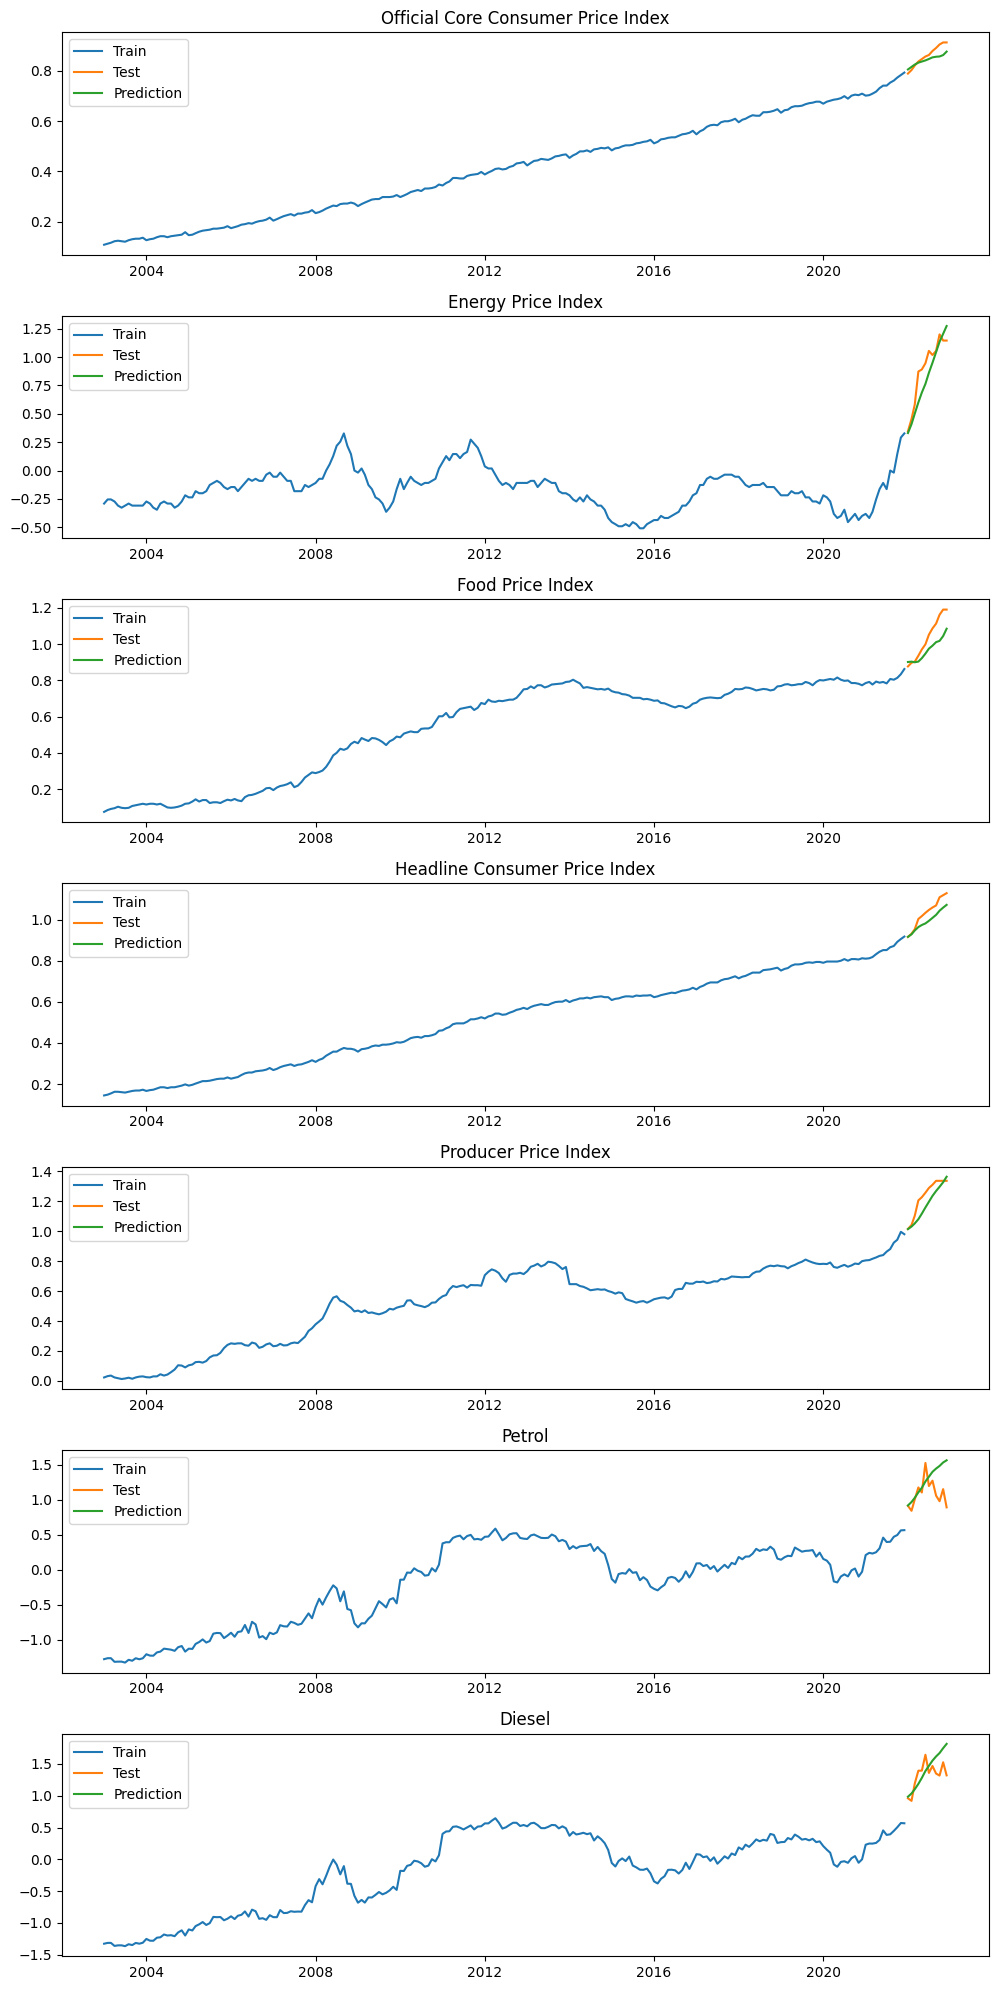

In [53]:
# merge the three dataframes on the index
merged_df = pd.concat([transformerTrainDF, transformerTestDF,transformerResultDF],axis=1)
merged_df
# plot the train, test, and prediction values


fig,axes = plt.subplots(7,1,figsize=(10,20),)

for i,col in enumerate(['Official Core Consumer Price Index','Energy Price Index','Food Price Index','Headline Consumer Price Index','Producer Price Index','Petrol','Diesel']):
    axes[i].plot(merged_df.index, merged_df[f"{col} Train"], label='Train')
    axes[i].plot(merged_df.index, merged_df[f"{col} Test"], label='Test')
    axes[i].plot(merged_df.index, merged_df[f"{col} Prediction"].add(dataGreaterthan2003DF[col][-12]), label='Prediction')
    axes[i].set_title(col)
    axes[i].legend()

fig.tight_layout()
plt.show()

merged_df.to_csv('univariate_transformer_results.csv', index = True)

### future prediction

In [ ]:
# dataGreaterthan2003DF = pd.read_csv('dataGreaterthan2003_20230313.csv')
# dataGreaterthan2003DF['Unnamed: 0'] = pd.to_datetime(dataGreaterthan2003DF['Unnamed: 0'])
# dataGreaterthan2003DF.set_index('Unnamed: 0', inplace=True)
# rawDF = dataGreaterthan2003DF

In [9]:
future_dates = pd.date_range('2022-11-01', '2027-10-01', freq='MS')
prediction_result = pd.DataFrame(index=future_dates)

for col in stationaryDataDF.columns:
    input_data = stationaryDataDF[[col]]
    scaled_input = input_data.to_numpy().reshape(-1)

    output_window = 60
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
    model = Transformer(d_model = 12, num_heads= int(12/4)).to(device)

    criterion = nn.MSELoss()

    lr = result_dict[col]['learning_rate']
    epochs = result_dict[col]['epochs']
    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
    for epoch in range(1, epochs + 1):
        model.train()
        output = model(torch.FloatTensor(scaled_input[-12:])) 
    
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()

    model.eval() 
    predictions = torch.FloatTensor([])
    with torch.no_grad():
        for i in range(0, int(output_window/12),1):
            input = torch.clone(torch.FloatTensor(scaled_input[-12:]))
            # input[-output_window:] = 0     
            output = model(input[-12:])  
            input = output  
            predictions = torch.cat((predictions, output[-12:]))
           
    prediction_result[col] = predictions.cpu().view(-1)

In [55]:
columns = ['Official Core Consumer Price Index','Energy Price Index','Food Price Index','Headline Consumer Price Index','Producer Price Index','Petrol','Diesel']
col_means = prediction_result.mean()
prediction_centered = prediction_result - col_means
prediction = prediction_centered.reset_index(drop=True)[columns]
eval_rolling_mean = rolling_mean[columns].tail(60).reset_index(drop=True)
eval_rolling_mean_subtracted = eval_rolling_mean - eval_rolling_mean.iloc[0]
eval_predictions = eval_rolling_mean_subtracted.reset_index()[columns].tail(60).add(prediction_centered.reset_index()[columns])

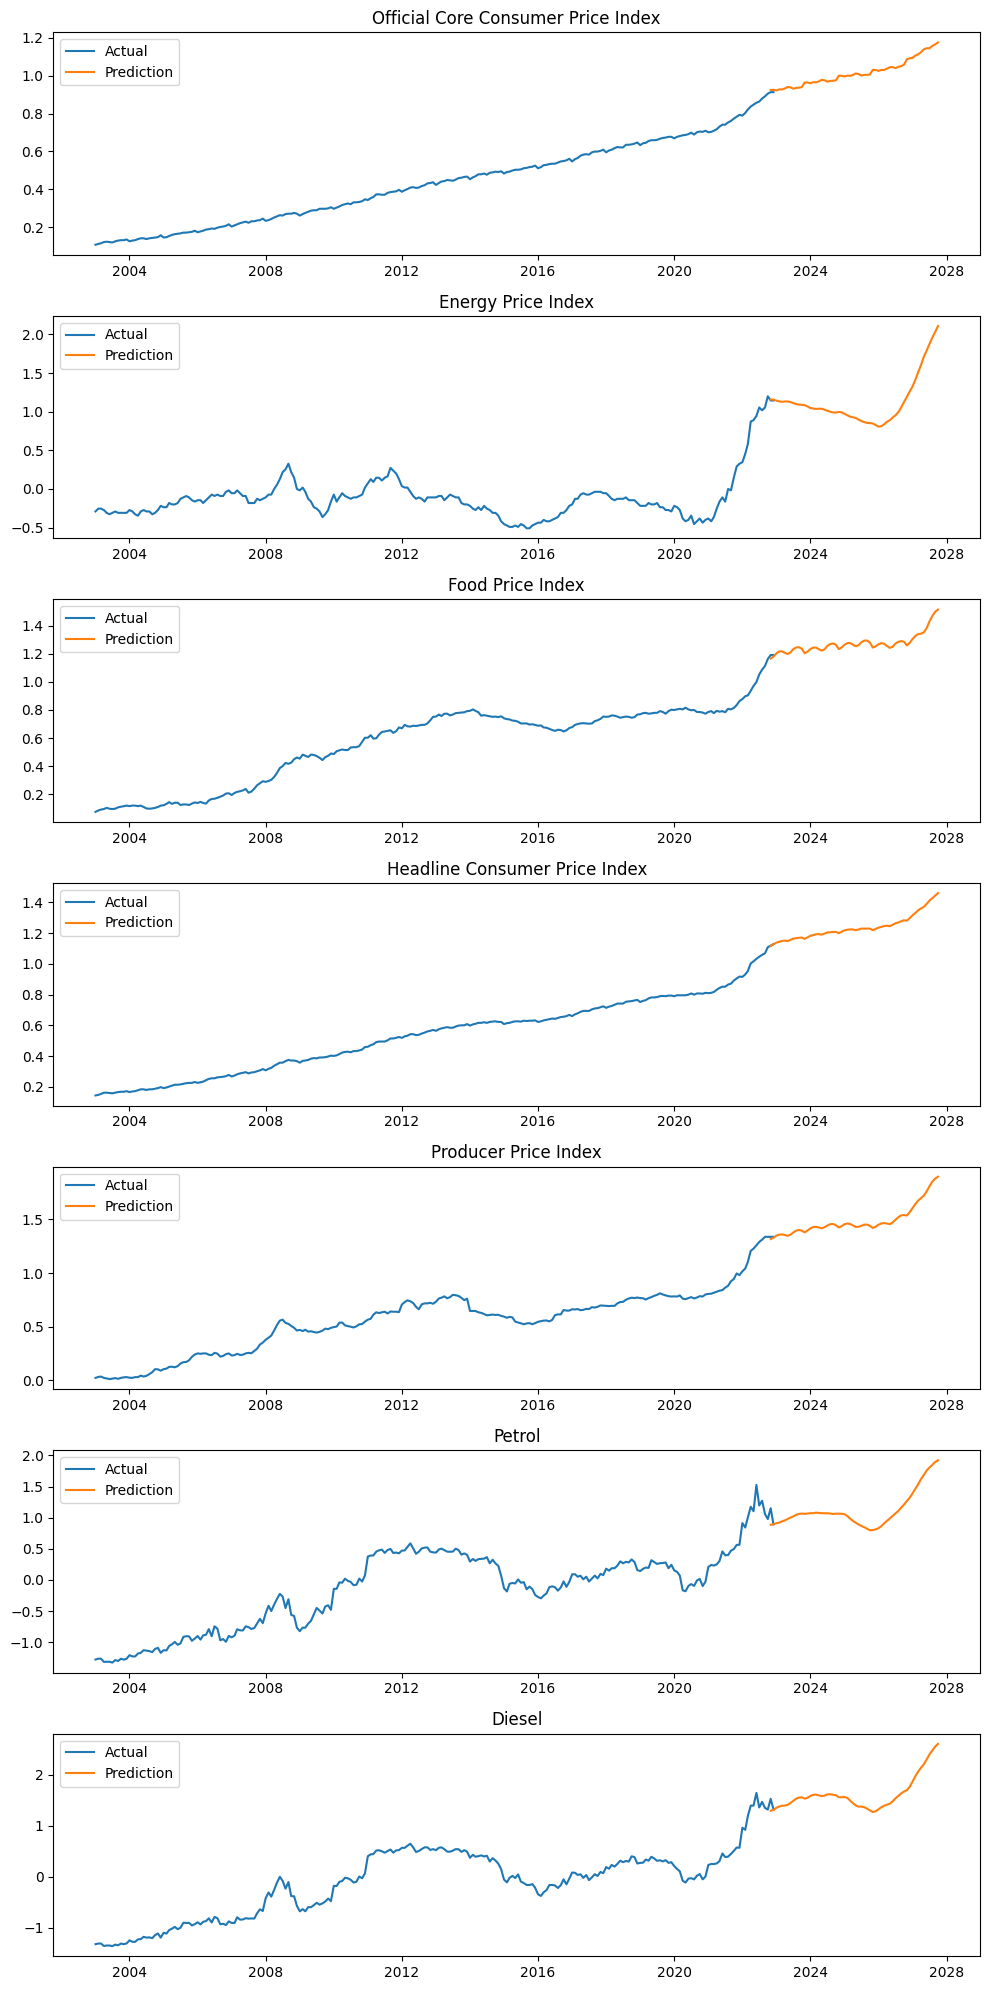

In [67]:
fig,axes = plt.subplots(7,1,figsize=(10,20),)

for i,col in enumerate(['Official Core Consumer Price Index','Energy Price Index','Food Price Index','Headline Consumer Price Index','Producer Price Index','Petrol','Diesel']):
    axes[i].plot(dataGreaterthan2003DF.index, dataGreaterthan2003DF[col], label='Actual')
    axes[i].plot(prediction_result.index, eval_predictions[col].add(dataGreaterthan2003DF[col][-1]), label='Prediction')
    axes[i].set_title(col)
    axes[i].legend()

fig.tight_layout()
plt.show()

## Multivariate Forecasting

### filtering principal components

In [10]:
principal_data = stationaryDataDF[['Producer Price Index', 'Energy Price Index', 'Official Core Consumer Price Index', 'Food Price Index','Petrol','Diesel']]

In [11]:
input_cols = ['Producer Price Index', 'Energy Price Index', 'Official Core Consumer Price Index', 'Food Price Index']
output_cols = ['Petrol','Diesel']

### hyperparameter tuning

In [ ]:
results = []

for col in output_cols:
    X_input_data = principal_data[input_cols]
    X_scaled_input = X_input_data.to_numpy().reshape(-1)

    y_input_data = principal_data[col]
    y_scaled_input = y_input_data.to_numpy().reshape(-1)

    samples = 100
    X_training_data = X_scaled_input[:samples]
    y_training_data = y_scaled_input[:samples]


    X_valuation_data = X_scaled_input[samples:]
    y_valuation_data = y_scaled_input[samples:]

    input_window = 100
    output_window = 10
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inout_seq = []
    L = len(training_data)
    for i in range(L-input_window):
        train_seq = np.append(X_training_data[i:i+input_window][:-output_window] , output_window * [0])
        train_label = y_training_data[i:i+input_window]
        inout_seq.append((train_seq ,train_label))
    train_data = torch.FloatTensor(inout_seq)
    train_data = train_data[:-output_window].to(device)

    inout_seq = []
    L = len(valuation_data)
    for i in range(L-input_window):
        val_seq = np.append(X_valuation_data[i:i+input_window][:-output_window] , output_window * [0])
        val_label = y_valuation_data[i:i+input_window]
        inout_seq.append((val_seq ,val_label))
    val_data = torch.FloatTensor(inout_seq)
    val_data = val_data[:-output_window].to(device)
    
    model = Transformer().to(device)

    criterion = nn.MSELoss()
    epochs_array = [50, 100, 150]
    learning_rate = [0.001, 0.01, 0.1]

    for lr in learning_rate:
        for epochs in epochs_array:
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
            for epoch in range(1, epochs + 1):
                model.train()
                total_loss = 0.

                for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
                    model.train()
                    output = model(torch.FloatTensor(X_valuation_data[-12:])) 
                
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                    optimizer.step()
                    scheduler.step()
                
                model.eval()
                total_loss = 0.
                eval_batch_size = 1000
                with torch.no_grad():
                    for i in range(0, len(val_data) - 1, eval_batch_size):
                        data, targets = get_batch(val_data, i,eval_batch_size)
                        output = model(data)            
                               
                        total_loss += len(data[i])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
                val_loss = total_loss / len(val_data)

                scheduler.step()
            results.append({'index': col, 'learning_rate': lr,'epochs': epoch, 'loss': val_loss})

# Convert results to a DataFrame
results = pd.DataFrame(results)

/shared-libs/python3.9/py/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [ ]:
# Group by 'index' column and find the minimum value of 'loss' column
min_values = results.groupby('index')['loss'].min()

# Filter original dataframe to only retain rows with minimum value for each group
result = results[results['loss'].isin(min_values)]

# If there are multiple rows with the same minimum loss value, choose the one with the minimum learning_rate and epochs
result = result.sort_values(['loss', 'learning_rate', 'epochs'], ascending=[True, True, True]).drop_duplicates(subset='index', keep='first')

# Set 'index' column as the new index
result.set_index('index', inplace=True)

# Output result
result


,learning_rate,epochs,loss
index,,,
Diesel,0.001,50,0.017221
Petrol,0.001,50,0.024423


In [12]:
# result.to_csv('transformerMultivariateHyperParameters.csv', index=True)
result = pd.read_csv('transformerMultivariateHyperParameters.csv').set_index('index')

In [13]:
result_dict = result.to_dict(orient='index')
result_dict

{'Diesel': {'learning_rate': 0.001, 'epochs': 50, 'loss': 0.0172208187480767},
 'Petrol': {'learning_rate': 0.001, 'epochs': 50, 'loss': 0.0244232422361771}}

### model implementation

In [32]:
result = {}

for col in output_cols:

    X_input_data = principal_data[input_cols]
    X_scaled_input = X_input_data.to_numpy().reshape(-1)

    y_input_data = principal_data[col]
    y_scaled_input = y_input_data.to_numpy().reshape(-1)

    X_training_data = X_scaled_input[:-12]
    y_training_data = y_scaled_input[:-12]


    X_valuation_data = X_scaled_input[-12:]
    y_valuation_data = y_scaled_input[-12:]

    input_window = 12
    output_window = 12
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = Transformer(d_model = 12, num_heads= int(12/4)).to(device)

    criterion = nn.MSELoss()

    lr = result_dict[col]['learning_rate']
    epochs = result_dict[col]['epochs']

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

    train_losses = []
    for epoch in range(1, epochs + 1):
        model.train()
        output = model(torch.FloatTensor(X_valuation_data[-12:])) 

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()


    model.eval() 

    predictions = torch.FloatTensor([])
    with torch.no_grad():
        for i in range(0, int(output_window/12),1):
            input = torch.clone(torch.FloatTensor(y_valuation_data[-12:]))    
            output = model(input[-12:])  
            input = output  
            predictions = torch.cat((predictions, output[-12:]))
            
    data = predictions.cpu().view(-1)
    
    result[col] = data[:12]

In [73]:
result = pd.DataFrame(result)

In [74]:
columns = ['Petrol','Diesel']
col_means = result.mean()
result_centered = result - col_means
result = result_centered.reset_index(drop=True)[columns]
eval_rolling_mean = rolling_mean[columns].tail(12).reset_index(drop=True)
eval_rolling_mean_subtracted = eval_rolling_mean - eval_rolling_mean.iloc[0]
eval_predictions = eval_rolling_mean_subtracted.reset_index()[columns].tail(12).add(result_centered.reset_index()[columns])
result = eval_predictions

### Evaluating model

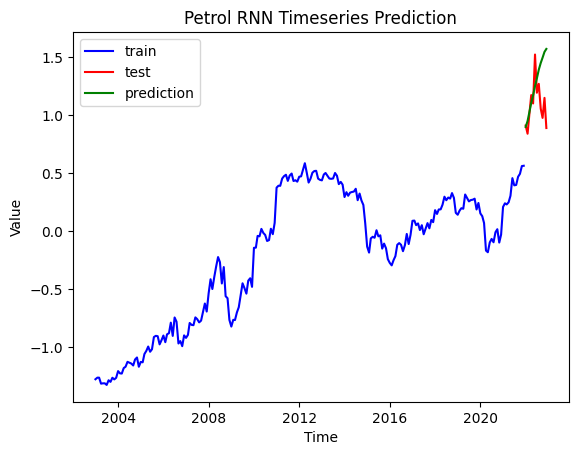

In [75]:

plt.plot(transformerTrainDF.index, dataGreaterthan2003DF['Petrol'][:-12], color='blue', label='train')
plt.plot(transformerTestDF.index, dataGreaterthan2003DF['Petrol'][-12:], color='red', label='test')
plt.plot(transformerTestDF.index, result['Petrol'].add(dataGreaterthan2003DF['Petrol'][-12]) , color='green', label='prediction')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Petrol RNN Timeseries Prediction')
plt.legend()

plt.show()

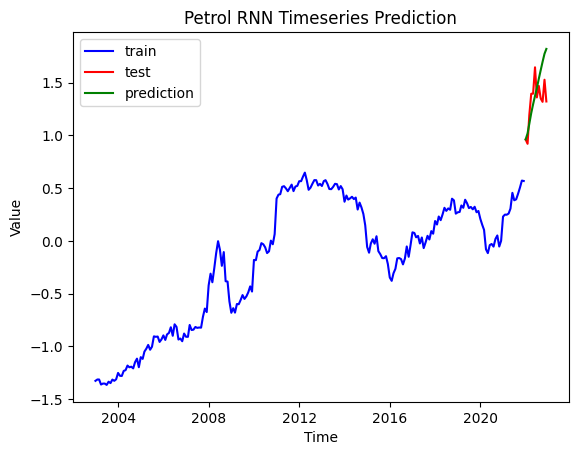

In [76]:
plt.plot(transformerTrainDF.index, dataGreaterthan2003DF['Diesel'][:-12], color='blue', label='train')
plt.plot(transformerTestDF.index, dataGreaterthan2003DF['Diesel'][-12:], color='red', label='test')
plt.plot(transformerTestDF.index, result['Diesel'].add(dataGreaterthan2003DF['Diesel'][-12]), color='green', label='prediction')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Petrol RNN Timeseries Prediction')
plt.legend()

plt.show()

### future prediction

In [109]:
future_dates = pd.date_range('2022-11-01', '2027-10-01', freq='MS')
multi_prediction_result = pd.DataFrame(index=future_dates)

for col in output_cols:
    X_input_data = principal_data[input_cols]
    X_scaled_input = X_input_data.to_numpy().reshape(-1)

    y_input_data = principal_data[col]
    y_scaled_input = y_input_data.to_numpy().reshape(-1)

    X_training_data = X_scaled_input[:-12]
    y_training_data = y_scaled_input[:-12]


    X_valuation_data = X_scaled_input[-12:]
    y_valuation_data = y_scaled_input[-12:]

    input_window = 12
    output_window = 60
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = Transformer(d_model = 12, num_heads= int(12/4)).to(device)

    criterion = nn.MSELoss()

    lr = result_dict[col]['learning_rate']
    epochs = result_dict[col]['epochs']

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
    for epoch in range(1, epochs + 1):
        model.train()
        output = model(torch.FloatTensor(X_valuation_data[-12:])) 
    
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
    
    model.eval() 

    predictions = torch.FloatTensor([])
    with torch.no_grad():
        for i in range(0, int(output_window/12),1):
            input = torch.clone(torch.FloatTensor(y_valuation_data[-12:]))    
            output = model(input[-12:])  
            input = output  
            predictions = torch.cat((predictions, output[-12:]))
           
    multi_prediction_result[col] = predictions.cpu().view(-1)

In [110]:
columns = ['Petrol','Diesel']
col_means = multi_prediction_result.mean()
result_centered = multi_prediction_result - col_means
result = result_centered.reset_index(drop=True)[columns]
eval_rolling_mean = rolling_mean[columns].tail(60).reset_index(drop=True)
eval_rolling_mean_subtracted = eval_rolling_mean - eval_rolling_mean.iloc[0]
eval_predictions = eval_rolling_mean.reset_index()[columns].tail(60).add(result_centered.reset_index()[columns])
multi_prediction_result = eval_predictions
multi_prediction_result.index = future_dates

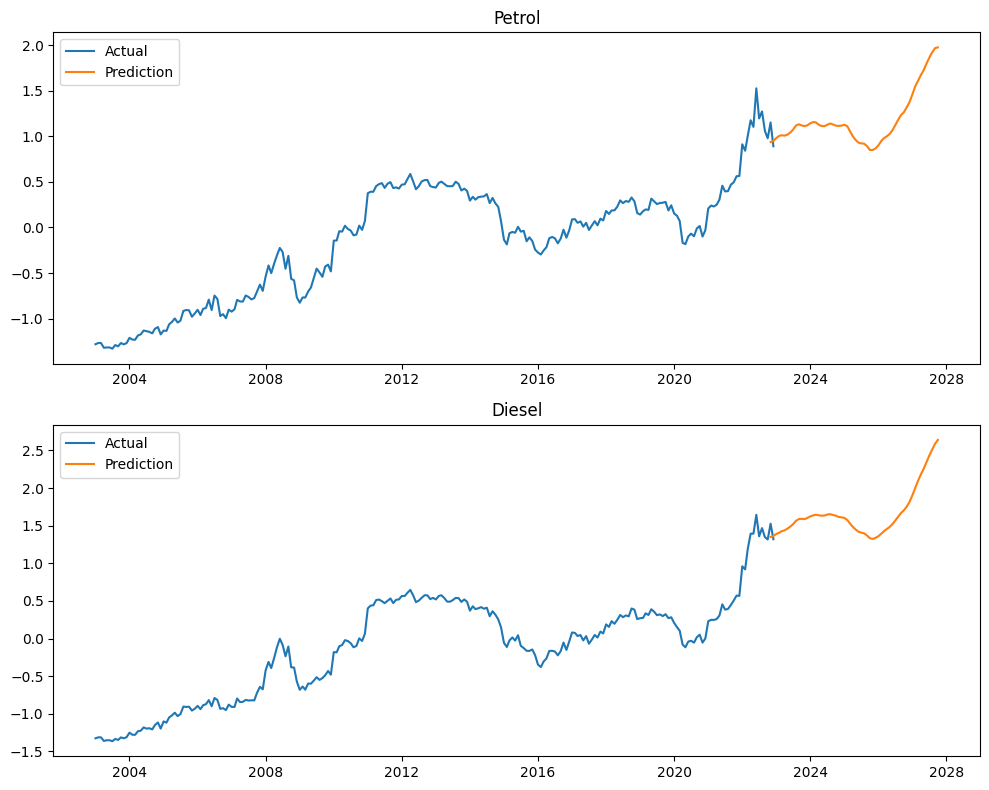

In [111]:
fig,axes = plt.subplots(2,1,figsize=(10,8),)

for i,col in enumerate(['Petrol','Diesel']):
    axes[i].plot(dataGreaterthan2003DF.index, dataGreaterthan2003DF[col], label='Actual')
    axes[i].plot(multi_prediction_result.index, multi_prediction_result[col].add(dataGreaterthan2003DF[col][-1]), label='Prediction')
    axes[i].set_title(col)
    axes[i].legend()

fig.tight_layout()
plt.show()

# multi_prediction_result.to_csv('multivariate_future_prediction_transformer.csv', index=True)

In [72]:
eval_predictions.index = future_dates

<AxesSubplot: >

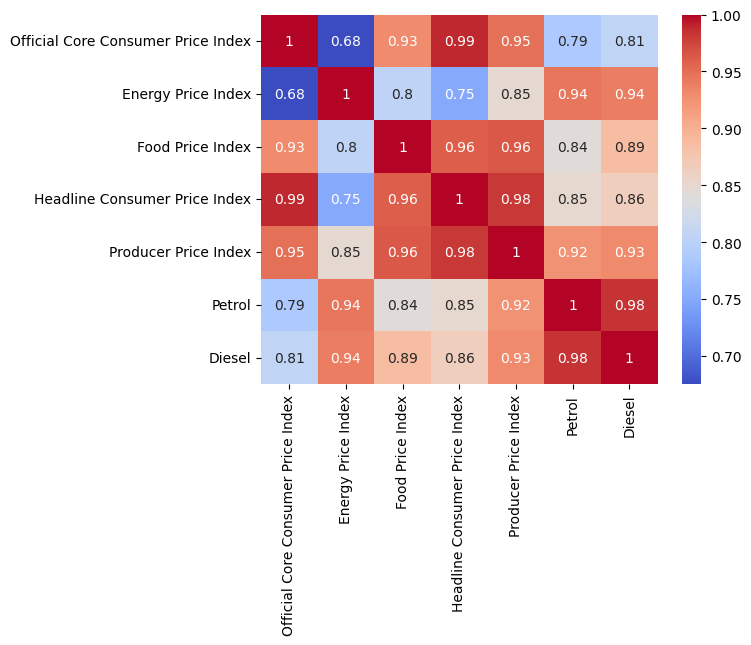

In [73]:
sns.heatmap(eval_predictions.corr(), cmap='coolwarm', annot=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=638889fe-2546-41ac-8d2f-f9d8b29d307c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>